
# 01. Acquisition operators
In the code we are simulating using class spyrit.core

* **Measurement operators** compute linear measurements $y = Hx$ where H is linear operator and x is image
* **Noise operator** 
* **Preprocessing operators** 


In [2]:
import numpy as np
import os
from spyrit.misc.disp import imagesc
import matplotlib.pyplot as plt

#### Load a batch of images



c:\Users\RAmsh\OneDrive\Desktop\gjbhjbkhb\spyrit-master\spyrit\tutorial
Shape of input images: torch.Size([7, 1, 64, 64])


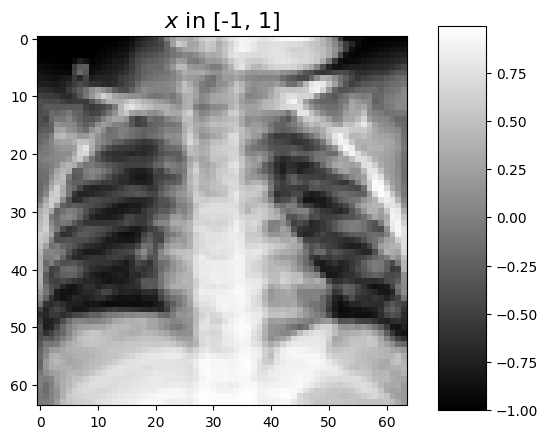

In [3]:

from spyrit.misc.statistics import transform_gray_norm
import torchvision
import torch

h = 64  # image size hxh
i = 1  # Image index (modify to change the image)
spyritPath = os.getcwd()
print(spyritPath)
imgs_path = os.path.join(spyritPath, "../images")


#  transform original images to normalized grayscale image tensors
transform = transform_gray_norm(img_size=h)

dataset = torchvision.datasets.ImageFolder(root=imgs_path, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=7)

x, _ = next(iter(dataloader))
print(f"Shape of input images: {x.shape}")

# Select image
x = x[i -1 : i  , :, :, :]
x = x.detach().clone()
b, c, h, w = x.shape

# plot
x_plot = x.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$x$ in [-1, 1]")

#### The measurement and noise operators



Noise operators are defined by  "spyrit.core.noise" module.


Pseudo inverse will not be instanciated
simulated output :  tensor([[0.0000, 0.0000, 0.0000,  ..., 0.7373, 0.6588, 0.6000]])


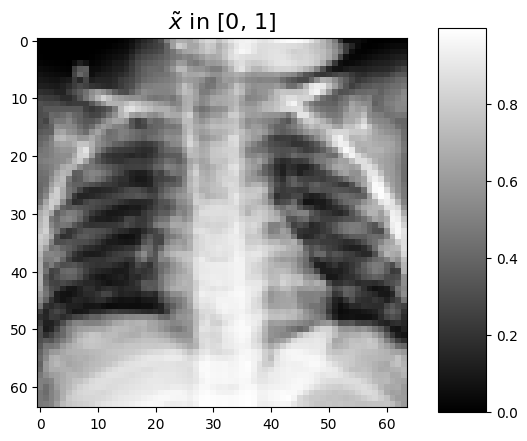

In [6]:
from spyrit.core.meas import Linear
from spyrit.core.noise import NoNoise
# H a measurement matrix and applying noiseless case 
meas_op = Linear(np.eye(h * h))
noise_op = NoNoise(meas_op)

x = x.view(b * c, h * w)  # vectorized image
#print(f"Shape of vectorized image: {x.shape}")
y_eye = noise_op(x)  # noisy measurement vector
#print(f"Shape of simulated measurements y: {y_eye.shape}")
print("simulated output : ", y_eye)
# plot
x_plot = y_eye.view(-1, h, h).cpu().numpy()
imagesc(x_plot[0, :, :], r"$\tilde{x}$ in [0, 1]")

<div class="alert alert-info"><h4>Note</h4><p>Note that the image identical to the original one, except it has been
  normalized in [0,1].</p></div>



## Same example with Poisson noise



We now consider Poisson noise, i.e., a noisy measurement vector given by
\begin{align}y \sim \mathcal{P}(\alpha H \tilde{x}),\end{align}

where $\alpha$ is a scalar value ->  represents the maximum image intensity
(in photons). 
* The larger $\alpha$, the higher the signal-to-noise ratio.



In [9]:
from spyrit.core.noise import Poisson
from spyrit.misc.disp import add_colorbar, noaxis

alpha = 100  # number of photons
noise_op = Poisson(meas_op, alpha)

#We simulate two noisy measurement vectors

y1 = noise_op(x)  # a noisy measurement vector
y2 = noise_op(x)  # another noisy measurement vector

noise_op.alpha = 1000
y3 = noise_op(x)  # noisy measurement vector

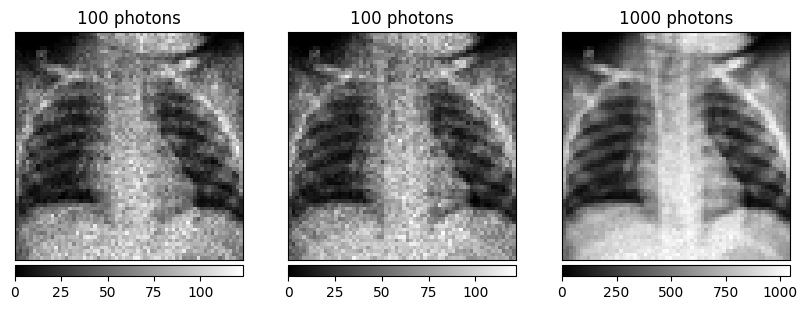

In [10]:
# plot
y1_plot = y1.view(b, h, h).detach().numpy()
y2_plot = y2.view(b, h, h).detach().numpy()
y3_plot = y3.view(b, h, h).detach().numpy()

f, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].set_title("100 photons")
im = axs[0].imshow(y1_plot[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

axs[1].set_title("100 photons")
im = axs[1].imshow(y2_plot[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

axs[2].set_title("1000 photons")
im = axs[2].imshow(y3_plot[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

noaxis(axs)

### calculate Signal to noise ratio 

In [15]:
noise_power_y1 = np.sqrt(np.mean(y1.numpy()))
noise_power_y2 = np.sqrt(np.mean(y2.numpy()))
noise_power_y3 = np.sqrt(np.mean(y3.numpy()))

# Calculate SNR for each noisy measurement vector
signal_power1=100
signal_power2=100
signal_power3=1000
SNR_y1 = signal_power1/ noise_power_y1
SNR_y2 = signal_power2 / noise_power_y2
SNR_y3 = signal_power3 / noise_power_y3

print("SNR for 100 photons (y1):", SNR_y1)
print("SNR for 100 photons (y2):", SNR_y2)
print("SNR for 1000 photons (y3):", SNR_y3)

SNR for 100 photons (y1): 13.497664661343553
SNR for 100 photons (y2): 13.514687247886704
SNR for 1000 photons (y3): 42.67844769649955


As expected the signal-to-noise ratio of the measurement vector is higher for
1,000 photons than for 100 photons




### Preprocessing measurements corrupted by Poisson noise
 
-> compensate for the scaling factors that appear in the measurement or noise operators.
* using Directpoission we are scaling up and undergoing affine transformation to get images in [0,1] from images in [-1,1]

In [16]:
from spyrit.core.prep import DirectPoisson

alpha = 100  # number of photons
prep_op = DirectPoisson(alpha, meas_op)
#We preprocess the first two noisy measurement vectors

m1 = prep_op(y1)
m2 = prep_op(y2)

# alpha =1000
prep_op.alpha = 1000
m3 = prep_op(y3)

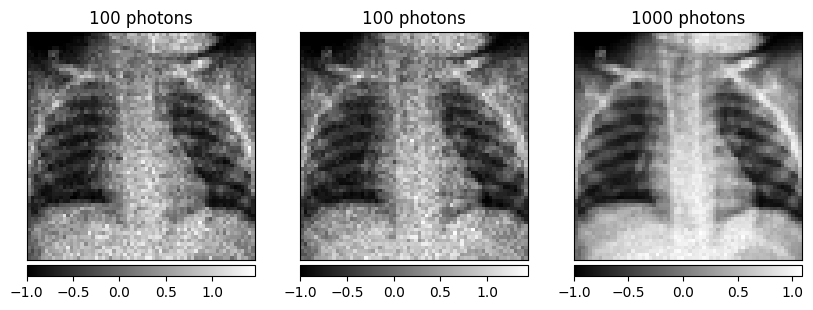

In [17]:
# plot
m1 = m1.view(b, h, h).detach().numpy()
m2 = m2.view(b, h, h).detach().numpy()
m3 = m3.view(b, h, h).detach().numpy()

f, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].set_title("100 photons")
im = axs[0].imshow(m1[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

axs[1].set_title("100 photons")
im = axs[1].imshow(m2[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

axs[2].set_title("1000 photons")
im = axs[2].imshow(m3[0, :, :], cmap="gray")
add_colorbar(im, "bottom")

noaxis(axs)

In [21]:
noise_power_m1 = np.sqrt(np.mean(m1))
noise_power_m2 = np.sqrt(np.mean(m2))
noise_power_m3 = np.sqrt(np.mean(m3))

# Calculate SNR for each noisy measurement vector
signal_power1=100
signal_power2=100
signal_power3=1000
SNR_y1 = signal_power1/ noise_power_m1
SNR_y2 = signal_power2 / noise_power_m2
SNR_y3 = signal_power3 / noise_power_m3

print("SNR for 100 photons (y1):", SNR_y1)
print("SNR for 100 photons (y2):", SNR_y2)
print("SNR for 1000 photons (y3):", SNR_y3)

SNR for 100 photons (y1): 319.80818999225033
SNR for 100 photons (y2): 324.4261388923186
SNR for 1000 photons (y3): 3193.9530985914957
